## Intro

This notebook contains a brief analysis of a data set about students. The data set includes
information about the students’ age, nationality, gender, as well as information
about their studying habits. There is also a binary column expressing whether or not
the students passed an important test.

The following information should be extracted from the data:
- Describe the demographic details of people most likely to pass the test
- Describe the efficacy of the two interventions - the test prep course and the
Dojo class
- Identify any other interesting trends from the data set and offer some analysis
as to their importance or cause.

## A Brief look into the data

Import the Libarys

In [300]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Creating the connection to the PostgreSQL database

In [301]:
# Read database string from .env file 
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

import the triad table from the PostgreSQL database

In [302]:
df_triad = pd.read_sql('SELECT * FROM takemehome.triad;', db)


Look into the dataframe

In [ ]:
df_triad.head()

if something has the name 'pass' it maybe will lead to problems later, so let's prevent it directly

In [304]:
df_triad.columns = df_triad.columns.str.replace('pass','pass_test')

from now on the column 'pass' will be named 'pass_test'  
  
So, now let's have a look which data the database includes:  

In [305]:
df_triad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   lang           5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass_test      5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.2+ KB


Database includes:
+ 5000 Students
+ sex, lang, country and notes are objects, i have to have a look which data they include and if i have to change the type
+ dojo_class, test_prep and pass_test are bool, age is type int, I expect to work with that

Missing Values: 
+ hours_studied and notes contains missing values
+ hours_studied contains 1982 missing values - until now, i don't know if i need this
+ notes contains 4228 missing values, that is very much, but, as long I am looking for test passing, I don't need this, so I will drop this column


In [306]:
df_triad = df_triad.drop('notes', axis=1)

then, I want to know if I have duplicate entries:

In [307]:
df_triad.duplicated().value_counts()

False    3648
True     1352
Name: count, dtype: int64

Yes, there are a lot of duplicated values.   
But that don't mean, that these entries are wrong. I don't have a student_id, so it is possible that some of the students have the same properties.  
  
  
I expect that The column _hours_studied_ contains a lot of different values, so let's see how much duplicated data are in this column:

In [308]:
df_triad.hours_studied.duplicated().value_counts()

hours_studied
False    3019
True     1981
Name: count, dtype: int64

The duplicated elements in the _hours_studied_ column are almost exact the same number like the missing values in this column (the first entry with missing value is not duplicated).  
So, the duplicated values in the whole dataframe can just contain the missing values in the _hours_studied_. If this were not the case, I would also have more duplicates in the _hours_studied_  column.  
  
And, as I said earlier, it is possible that some of the students have the same properties. So i will keep the _duplicated_ data in my dataframe. 

---
Question: How much Students pass the test and how much not:  
  
count...  

In [309]:
df_triad.pass_test.value_counts()

pass_test
False    2665
True     2335
Name: count, dtype: int64

and in % ...

In [310]:
df_triad.pass_test.value_counts(normalize=True)

pass_test
False    0.533
True     0.467
Name: proportion, dtype: float64

It sad, but it's True, the most students didn't pass the test. Just 46.7% pass it. 

---
I want to know what 'lang' contains:

In [311]:
df_triad.lang.value_counts()

lang
Japanese    4022
English      528
Italian      145
Spanish      132
French       128
Finnish       45
Name: count, dtype: int64

so 'lang' seems to be the native language of the student  

interesting, so lets see, from which countrys the students are:

In [312]:
df_triad.country.value_counts()

country
Japan          4022
Italy           145
USA             140
Australia       134
New Zealand     131
France          128
UK              123
Mexico           73
Spain            59
Finland          45
Name: count, dtype: int64

The sums of students with  _country = Japan_ and _language = japanese_ are the same, so we can say that up to 20% of the students are not from Japan and they don't speak japanese as there native language. Lets see later if that have an influence to the test passing or not.
 

## Analysis 

Let's start with the plots to see more from the data... 
  
Since I am interested in whether the student passed or failed the important test, I will divide the graphics directly into pass and fail.   

And to prevent repeating but write some words to describe each plot, it will create a small function:

In [313]:
def cat_plot_colored_pass_test(item:str, title:str):
    
    plt.figure()
    g=sns.catplot(data = df_triad, x=item, hue ='pass_test', kind='count').set(xlabel='', title = title)
    ax = g.facet_axis(0,0)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    sns.move_legend(g, "upper right", title='test result',  labels=['fail', 'pass'], bbox_to_anchor=(1.0, 1.0))
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')
    plt.show();

---
We start with a look at the dates for the visit of the preparation class. I expect, the visit of the test preparation class will lead to success.

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


<Figure size 640x480 with 0 Axes>

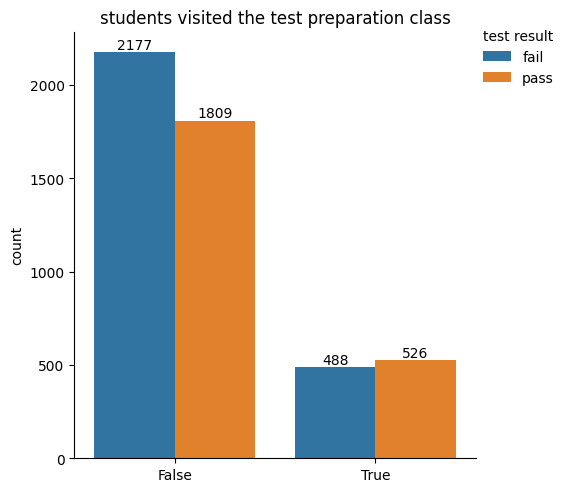

In [314]:
cat_plot_colored_pass_test('test_prep', 'students visited the test preparation class')

Short Plot description: 
+ the bars on the left show the number of students who did ***not attend*** the class
+ the bars on the right show the number of student who did ***attend*** the class
+ the blue bars shows the number of students who ***failed*** the test
+ the orange bar shows the number of students who ***passed*** the test
+ at the top of the bars is the total number of the students in this group

At first glance, we can see that the majority of students have not attended the course. And the majority of these students also failed the test. But also a high number of students pass the test, even when they didn't attend the course.  
  
A smaller number of students visit the course, but only a little more than half of these students passed the test, there is a high failure rate even with attending the preparatory class.   

If we assume that the students who need better preparation also attend the preparatory class, then they improve their chances of passing the test to almost 50%. But attending this preparatory class is by no means a guarantee of passing the test. 

---
Now we look into the data to see whether attending the dojo class has a better effect to pass the test.

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


<Figure size 640x480 with 0 Axes>

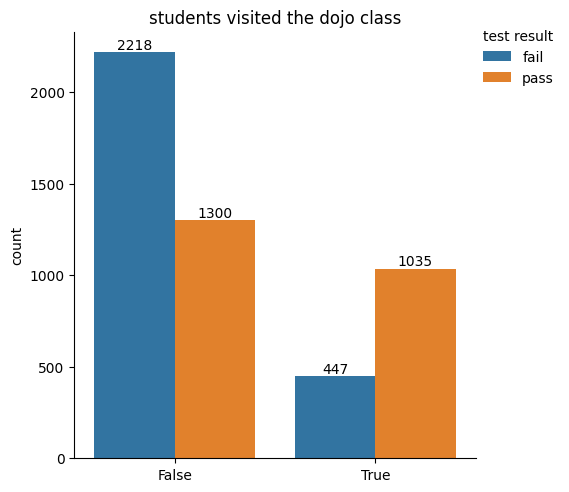

In [315]:
cat_plot_colored_pass_test('dojo_class', 'students visited the dojo class')

Short Plot description: 
+ the bars on the left show the number of students who did ***not attend*** the class
+ the bars on the right show the number of student who did ***attend*** the class
+ the blue bars shows the number of students who ***failed*** the test
+ the orange bar shows the number of students who ***passed*** the test
+ at the top of the bars is the total number of the students in this group

This look better. There is still a bigger group of students who didn't visit the dojo class and the most of them failed the test. 
But, when we look at the bars for the group of students who visited the dojo class we can see, that much more students of these group pass the test.  
So it seems, that visiting the dojo class brings more success to the test result than the test preparation class! 

I am interested to see if some student visit both classes and how there results are.   
Therefore I have to create a new colum in my database to collect the information. And later on, I will create a new plot. 

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


<Figure size 640x480 with 0 Axes>

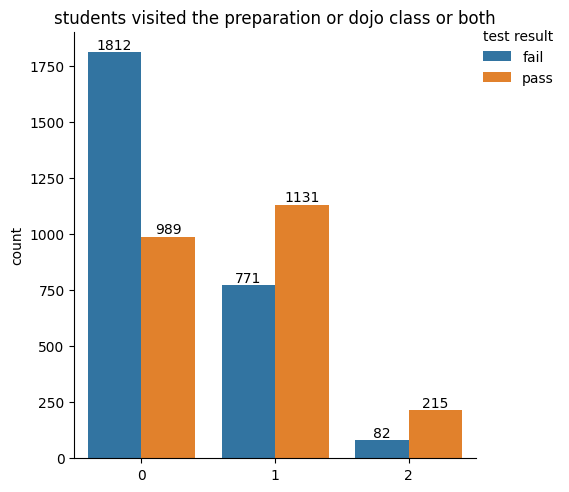

In [316]:
df_triad['prep_and_dojo'] = df_triad['dojo_class'].astype(int) + df_triad['test_prep'].astype(int)
cat_plot_colored_pass_test('prep_and_dojo', 'students visited the preparation or dojo class or both')

Short Plot description: 
+ the two bars on the left show the number of students who did ***not attend*** any class
+ the two bars in the middle show the number of student who did ***attend*** at least one class
+ the two bars on the right show the number of student who did ***attend*** both classes
+ again the blue bars shows the number of students who ***failed*** the test
+ and the orange bar shows the number of students who ***passed*** the test
+ at the top of the bars is the total number of the students in each group

Just a small group of student visit both classes. Also in this group we can see, that the chance of passing the test is more higher. But the change is not so much higher than with just visiting the dojo class. So the students can save their time and attend just the dojo class for better outcome in the test result. 
 

---
A large proportion of students indicated how many hours they had studied. Let's see if this also has an influence on the test result.  

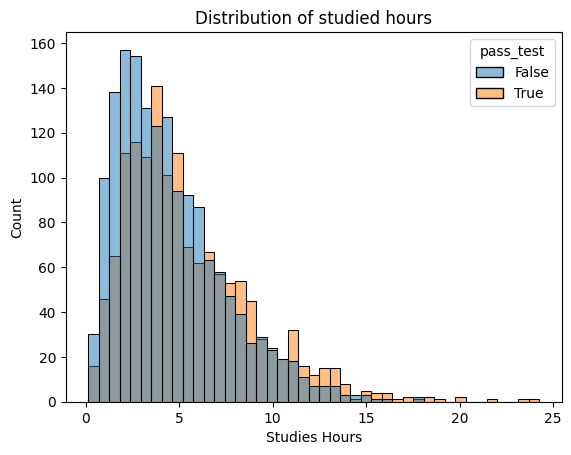

In [328]:
sns.histplot(data = df_triad, x='hours_studied', hue ='pass_test', legend= True).set(xlabel='Studies Hours', title = 'Distribution of studied hours');

Short Plot description: 
+ the plot shows the distribution of the studied hours in two categorys (blue and orange), the categories overlap each other
+ blue = distribution of studied hours from students who ***failed*** the test
+ orange = distribution of studied hours from students who ***passed*** the test

The distribution of hours studied by students who have passed the test is slightly shifted upwards. This indicates that more study also brings better results. In the upper range from 15 hours upwards, there are hardly any failures. However, there are also fewer students there.   


---
Now we want to look at the age of the students. Will there be an influence to the test result?   

I expect a larger age range than just 2-3 groups, so I will not use the function for this plot, but write the code myself and create a plot with different aspect.  

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


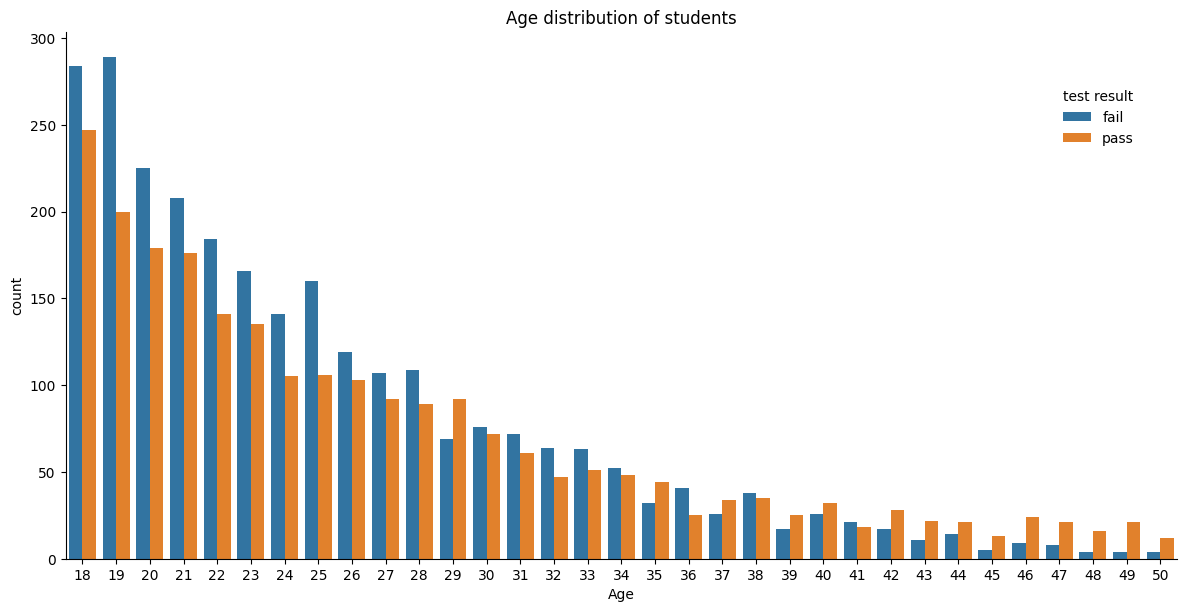

In [330]:
p = sns.catplot(data = df_triad, x='age', hue ='pass_test', kind='count', height=6., aspect=2./1.).set(xlabel='Age', title = 'Age distribution of students')
sns.move_legend(p, "upper right", title='test result',  labels=['fail', 'pass'], bbox_to_anchor=(0.9, 0.9))

Short Plot description: 
+ for each age there are 2 bars:
+ blue = number of students who ***failed*** the test
+ orange = the number of students who ***passed*** the test

There are a lot of bars... But if you take a closer look, you can see a few things: 
+ there are much more junger students than older ones
+ the distribution is continuously decreasing, there are students in every age group between 18 and 50
+ The students fail more often at younger ages and less often at older ages
+ from 18-28 years the chance to fail the test is higher, and above 39 the chance to pass the test in your age class is higher 
+ Between these ages there is a mixed area with different opportunities per age group
 

---
Now we will have a look into the rest of the data whether we also see a connection with the test result there. The gender of the Student, their native language and country of origin are still missing. 

We start with the gender:

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


<Figure size 640x480 with 0 Axes>

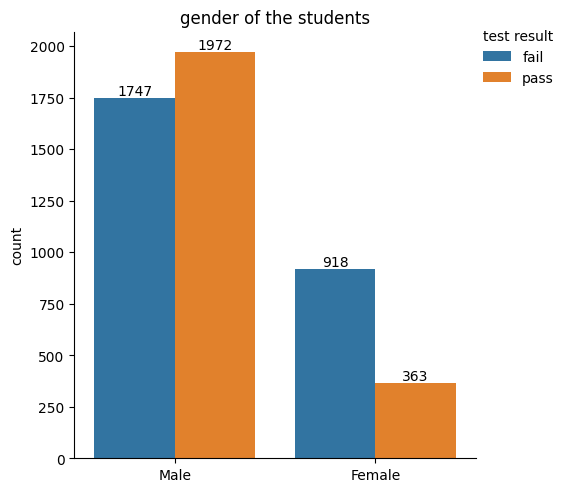

In [319]:
cat_plot_colored_pass_test('sex', 'gender of the students')

Short Plot description: 
+ the 2 bars on the left show the number of male students
+ the 2 bars on the right show the number of female students
+ the blue bars shows the number of students who ***failed*** the test
+ the orange bar shows the number of students who ***passed*** the test
+ at the top of the bars is the total number of the students in this group

The group of female students is much smaller, but many more students from this group fail the test than pass it. In contrast, the group of male students is almost three times larger and more students in this group pass the test.   
If we remember the overall student numbers, we know that more than half of the students fail the test. However, we do not see this behaviour if we look at male students only. So there must be a reason why the female students do so much worse than the male students.   
The gender has a high impact to the result of the test. 

---
Now, at least we take a look into the country and language values. As we have seen before, approximately 20% of the students are non-native Japanese. We will look at the data as 2 groups (Japanese and non-Japanese). For this, I will create a new column in the table with the entry True for Japanese and False for non-Japanese. Then I will create the plot as usual. 

In [321]:
df_triad['japanese'] = df_triad['lang'].map(lambda x: x == 'Japanese').astype(int)
df_triad['japanese'] = df_triad['japanese'].map({0: 'other', 1: 'japanese' })

/Users/maritaschmidt/NEUE_FISCHE/ds-take-me-home-challenges/.venv/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


<Figure size 640x480 with 0 Axes>

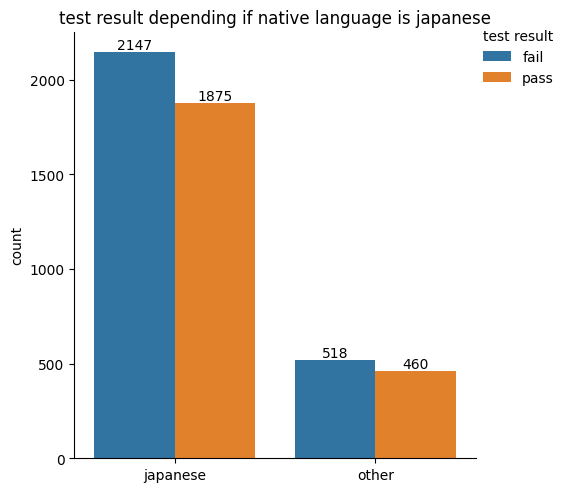

In [322]:
cat_plot_colored_pass_test('japanese', 'test result depending if native language is japanese')

Short Plot description: 
+ the 2 bars on the left show the number of japanese students
+ the 2 bars on the right show the number of students fromt other countries
+ the blue bars shows the number of students who ***failed*** the test
+ the orange bar shows the number of students who ***passed*** the test
+ at the top of the bars is the total number of the students in this group

We have roughly the same distribution of students who passed the test in both groups. so it has no influence on the test result whether the students have Japanese as their mother tongue or come from another country. 

## Conclusion:

The biggest influence for a positive test result is the attendance of the dojo class and whether the student is male. A higher age and a higher number of studies hours are also factors. 

## Outlook

If someone wants to improve the overall test results, there are a number of factors that can be addressed:

+ the dojo class seems to be much more effective than the test preparation class. You could convert the Preparation class into a Dojo class to have 2 very effective classes instead of just one. 
+ The group of young students is very large, and many of them fail the test. If you find out which mechanisms lead to this, you can tackle them in order to overcome them. 
+ The same applies to female students, they fail the tests much more often. What are the reasons for this and how can they be overcome?


